# Flow Matching for MNIST Generation - Complete with Experiments

This notebook implements Flow Matching (Conditional Flow Matching), a simpler alternative to DDPM.

**Key differences from DDPM:**
1. Uses straight-line interpolation paths: x_t = t*x_1 + (1-t)*x_0
2. Learns velocity field v_t instead of noise prediction
3. Sampling via ODE integration (simpler than iterative denoising)
4. Often more stable training and faster sampling

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy import linalg
import math

## 1. Model Architecture

In [9]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class VelocityNet(nn.Module):
  """A time-dependent velocity network built upon U-Net architecture."""

  def __init__(self, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent velocity network.

    Args:
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    return h

In [10]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

## 2. Flow Matching Implementation

In [11]:
class FlowMatching(nn.Module):
    """
    Flow Matching (Conditional Flow Matching)

    Reference:
    - "Flow Matching for Generative Modeling" (Lipman et al., 2023)
    - "Improving and Generalizing Flow-Based Generative Models" (Albergo et al., 2023)
    """

    def __init__(self, network, sigma=0.0):
        """
        Initialize Flow Matching Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used to predict velocity field. Typically a Unet.
        sigma: float
            Standard deviation for Gaussian perturbation.
            sigma=0: Optimal Transport Flow Matching (OT-CFM)
            sigma>0: Stochastic interpolant for improved stability
        """
        super().__init__()
        self._network = network
        self.sigma = sigma

        # Wrapper to handle input reshaping
        self.network = lambda x, t: (
            self._network(x.reshape(-1, 1, 28, 28), t)
        ).reshape(-1, 28*28)

    def interpolant(self, x0, x1, t):
        """
        Compute interpolant x_t between source x0 and target x1

        x_t = t*x1 + (1-t)*x0 + sigma*t*(1-t)*epsilon

        Parameters
        ----------
        x0: Tensor (batch_size, dim)
            Source samples (typically noise)
        x1: Tensor (batch_size, dim)
            Target samples (data)
        t: Tensor (batch_size, 1)
            Time in [0, 1]

        Returns
        -------
        xt: Tensor (batch_size, dim)
            Interpolated samples
        """
        t = t.view(-1, 1)
        mean = t * x1 + (1 - t) * x0

        # Add stochastic perturbation if sigma > 0
        if self.sigma > 0:
            std = self.sigma * t * (1 - t)
            epsilon = torch.randn_like(x0)
            return mean + std * epsilon

        return mean

    def conditional_velocity(self, x0, x1, t):
        """
        Compute target conditional velocity field

        For straight-line paths: u_t = x1 - x0

        Parameters
        ----------
        x0: Tensor (batch_size, dim)
            Source samples
        x1: Tensor (batch_size, dim)
            Target samples
        t: Tensor (batch_size, 1)
            Time (not used for straight paths)

        Returns
        -------
        velocity: Tensor (batch_size, dim)
            Target velocity field
        """
        return x1 - x0

    def loss(self, x1):
        """
        Compute Flow Matching training loss

        L = E[||v_theta(x_t, t) - u_t||^2]

        Parameters
        ----------
        x1: Tensor (batch_size, dim)
            Data samples

        Returns
        -------
        loss: Tensor (scalar)
            MSE loss
        """
        # Sample time uniformly in [0, 1]
        t = torch.rand(x1.shape[0], 1, device=x1.device)

        # Sample source from standard Gaussian
        x0 = torch.randn_like(x1)

        # Compute interpolant
        xt = self.interpolant(x0, x1, t)

        # Compute target velocity
        target_velocity = self.conditional_velocity(x0, x1, t)

        # Predict velocity
        predicted_velocity = self.network(xt, t.squeeze())

        # MSE loss
        return F.mse_loss(predicted_velocity, target_velocity)

    @torch.no_grad()
    def sample(self, shape, num_steps=50, method='euler'):
        """
        Generate samples by integrating the learned ODE

        dx/dt = v_theta(x, t),  x(0) ~ N(0, I)

        Parameters
        ----------
        shape: tuple
            Shape of samples to generate (batch_size, dim)
        num_steps: int
            Number of integration steps
        method: str
            Integration method: 'euler' or 'rk4'

        Returns
        -------
        x: Tensor (batch_size, dim)
            Generated samples
        """
        device = next(self.parameters()).device

        # Start from noise
        x = torch.randn(shape, device=device)
        dt = 1.0 / num_steps

        if method == 'euler':
            # Euler method: x_{i+1} = x_i + dt * v(x_i, t_i)
            for i in range(num_steps):
                t = torch.full((shape[0],), i * dt, device=device)
                v = self.network(x, t)
                x = x + dt * v

        elif method == 'rk4':
            # Runge-Kutta 4th order
            for i in range(num_steps):
                t = i * dt
                t_tensor = torch.full((shape[0],), t, device=device)
                t_half = torch.full((shape[0],), t + dt/2, device=device)
                t_next = torch.full((shape[0],), t + dt, device=device)

                k1 = self.network(x, t_tensor)
                k2 = self.network(x + dt/2 * k1, t_half)
                k3 = self.network(x + dt/2 * k2, t_half)
                k4 = self.network(x + dt * k3, t_next)

                x = x + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

        return x

## 3. Training Setup and Execution

In [12]:
def train(model, optimizer, scheduler, dataloader, epochs=50, device='cuda', ema=True, per_epoch_callback=None):
    """
    Training loop for Flow Matching

    Parameters
    ----------
    model: nn.Module
        Flow Matching model
    optimizer: optim.Optimizer
        Pytorch optimizer
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)

    # Store losses for plotting
    losses = []

    for epoch in range(epochs):

        # Switch to train mode
        model.train()
        epoch_loss = 0

        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()

            # Update progress bar
            progress_bar.set_postfix(
                loss=f"⠀{loss.item():12.4f}",
                epoch=f"{epoch+1}/{epochs}",
                lr=f"{scheduler.get_last_lr()[0]:.2E}"
            )
            progress_bar.update()

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter % ema_steps == 0:
                    ema_model.update_parameters(model)

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)

        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else model)

    return losses, (ema_model if ema else model)

In [13]:
# Parameters
learning_rate = 1e-3
epochs = 100
batch_size = 256
sigma = 0.0  # 0.0 for OT-CFM, try 0.001-0.01 for more stability

# Data preprocessing (same as DDPM)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, 1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

# Test dataset for evaluation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x-0.5)*2.0),
])
dataloader_test = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', download=True, train=False, transform=transform_test),
    batch_size=100,
    shuffle=False
)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Construct Unet for velocity prediction
velocity_net = VelocityNet()

# Construct Flow Matching model
model = FlowMatching(velocity_net, sigma=sigma).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

Using device: cuda:0
Total parameters: 1,115,425


Starting training...


Training:   0%|          | 0/23500 [00:00<?, ?it/s]

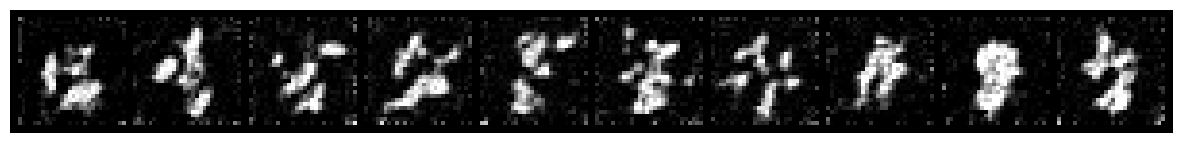

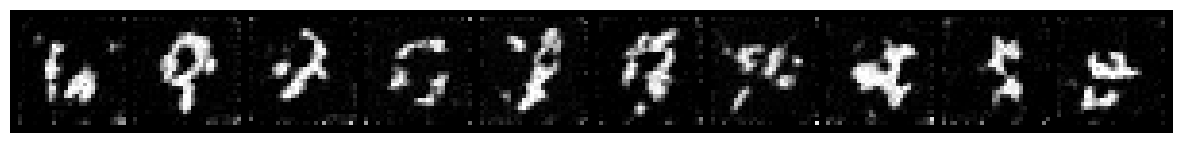

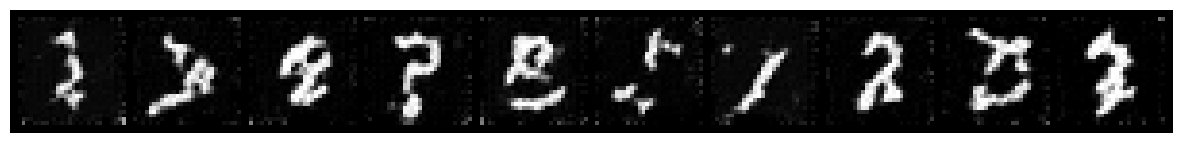

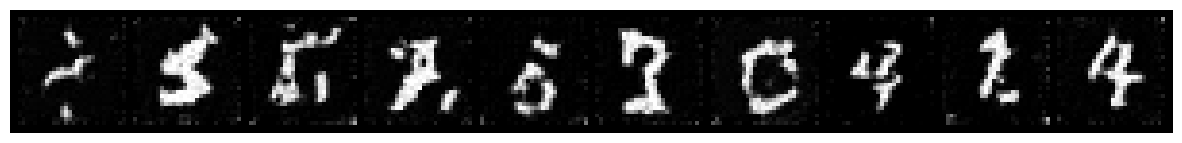

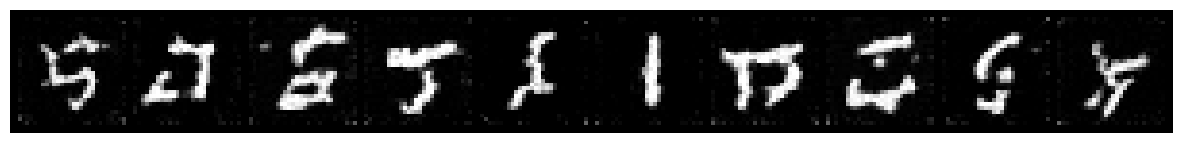

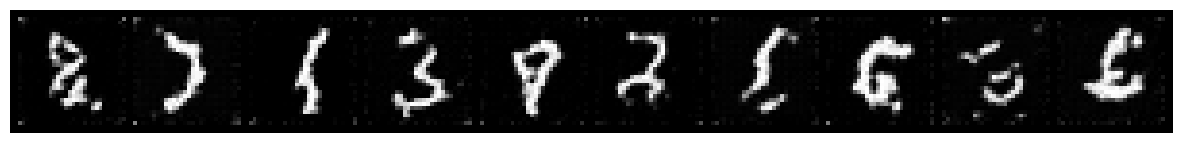

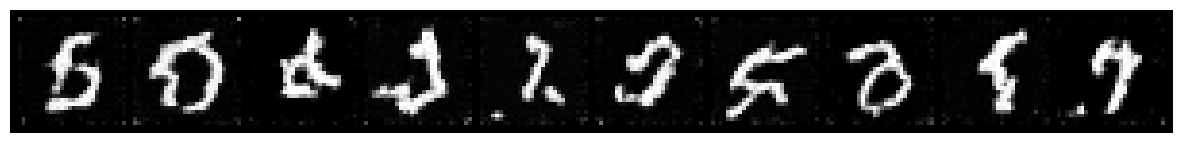

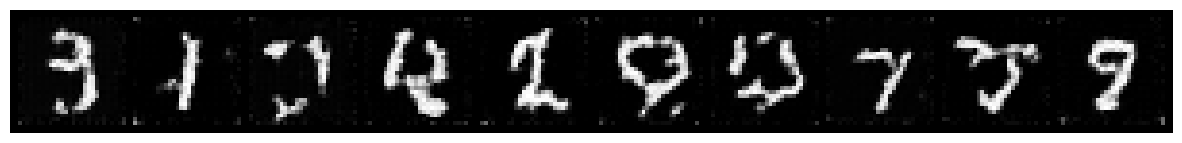

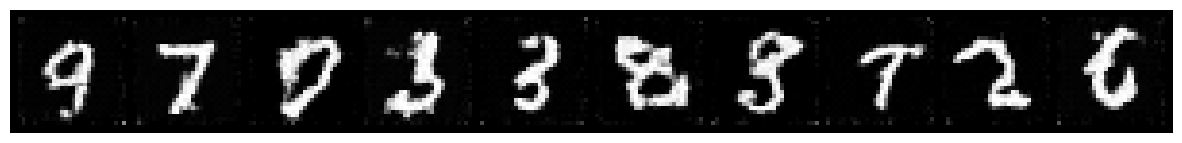

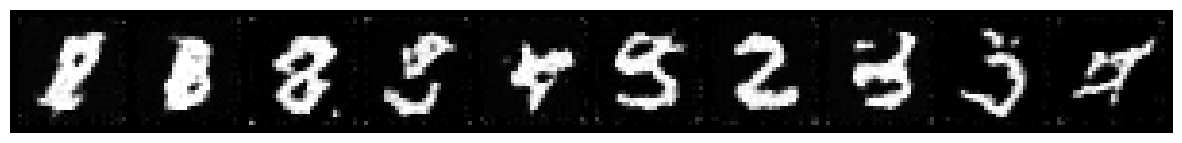

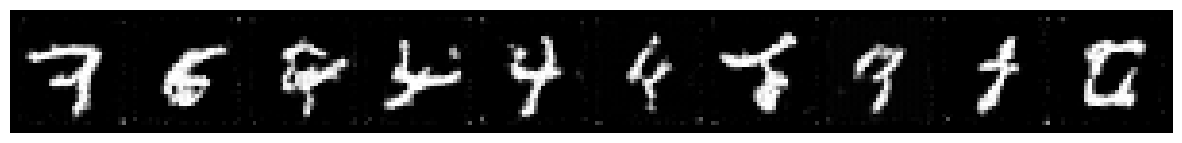

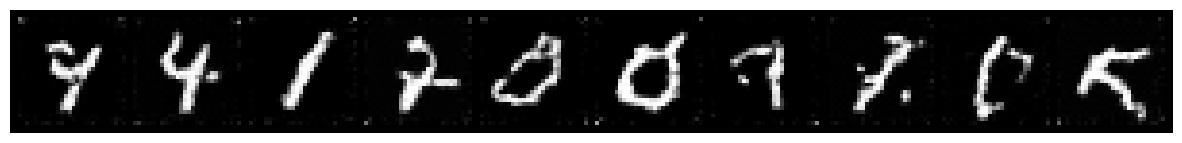

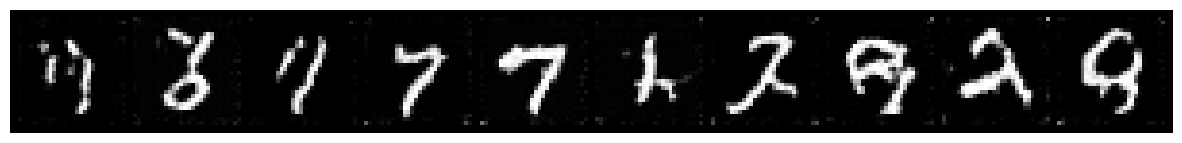

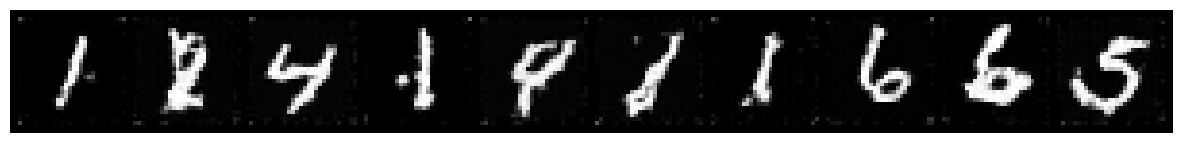

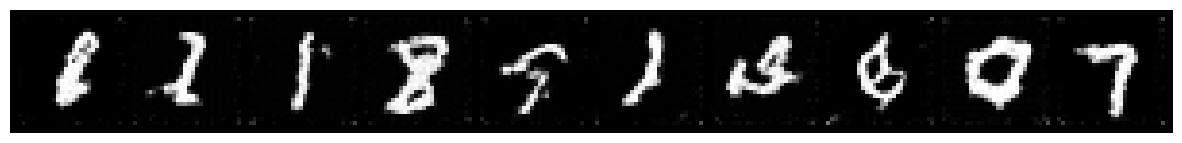

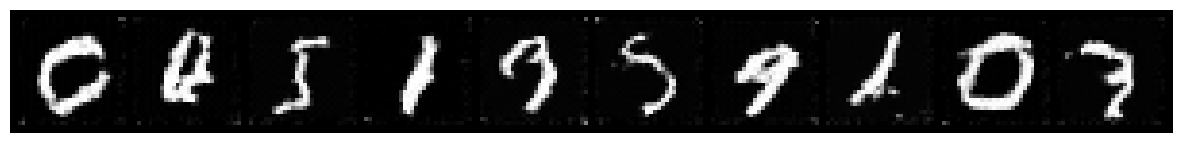

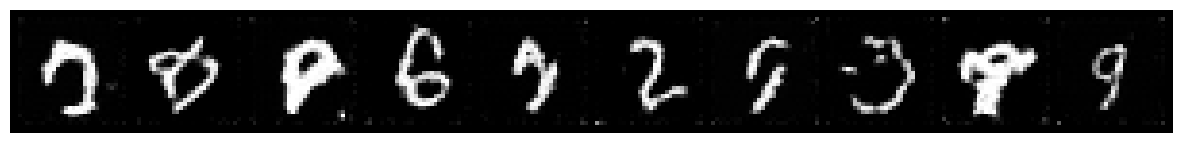

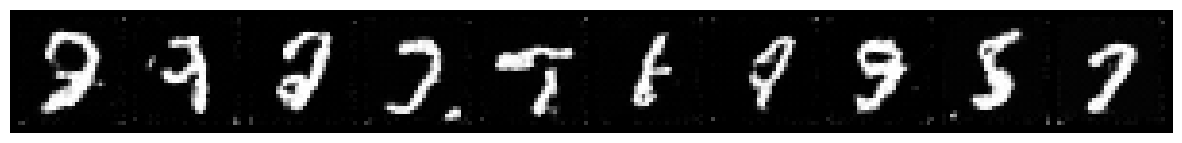

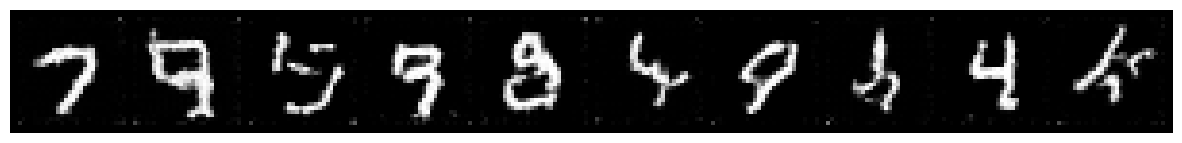

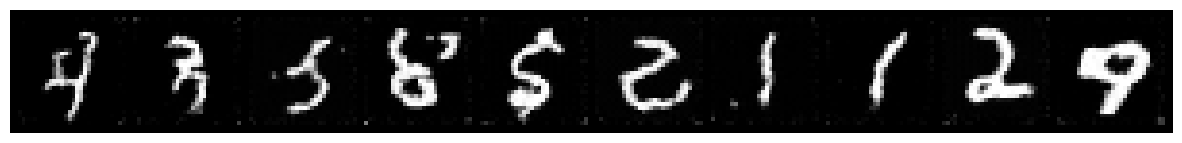

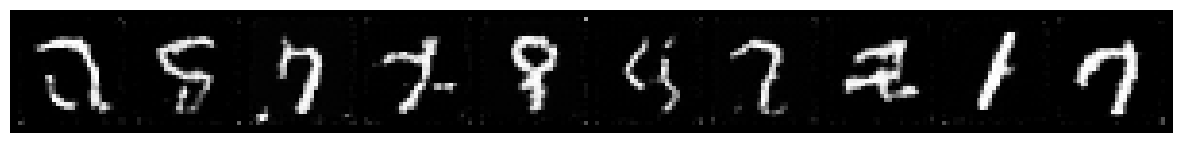

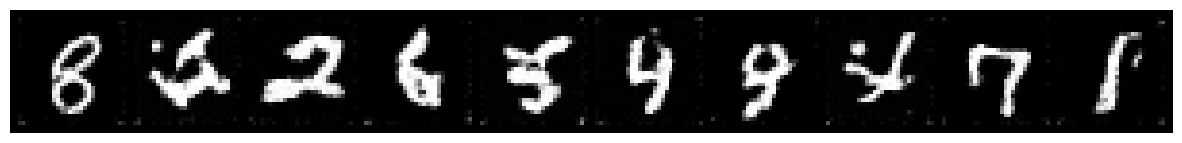

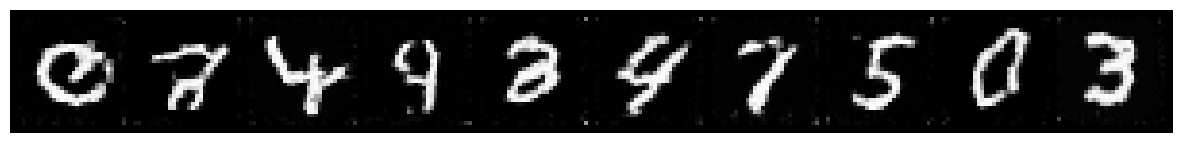

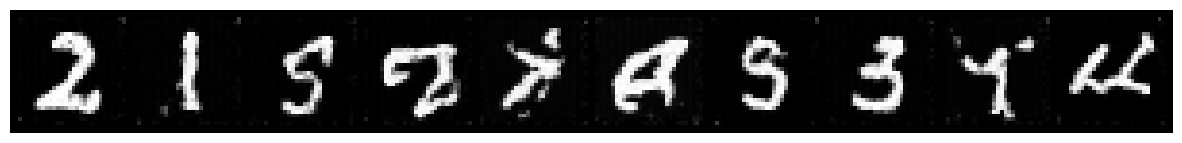

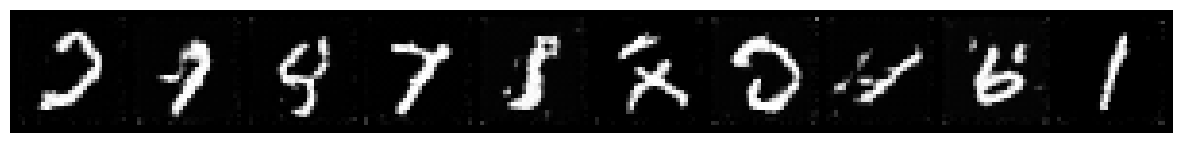

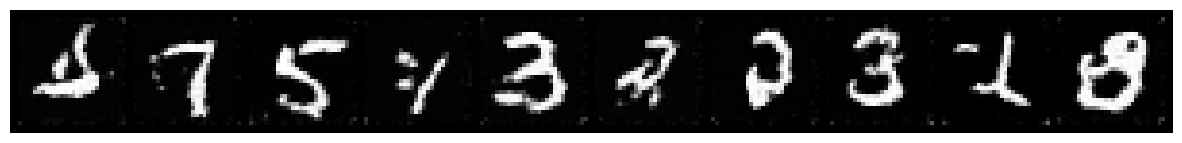

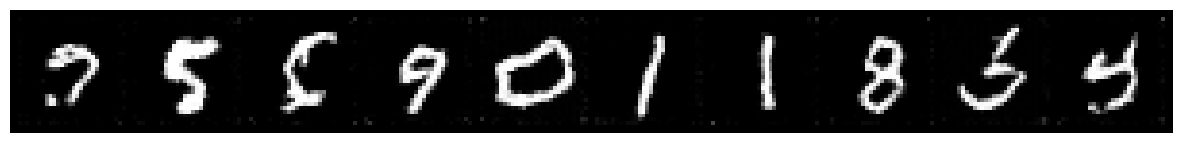

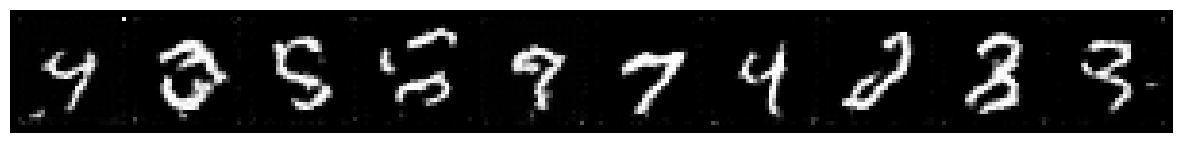

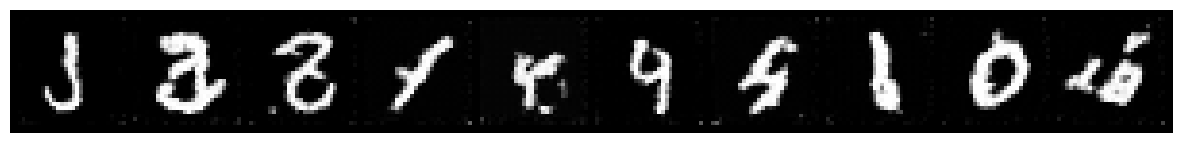

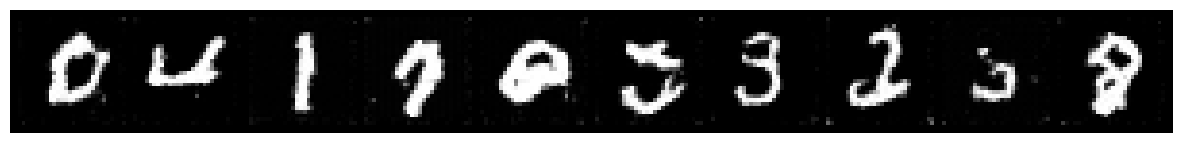

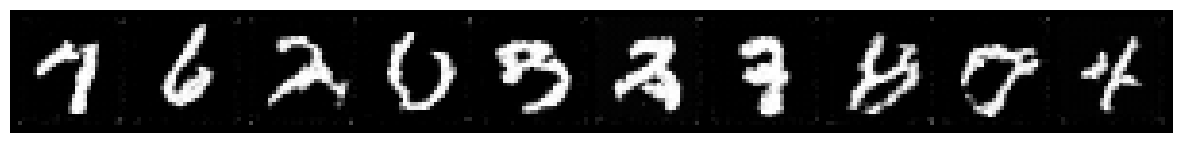

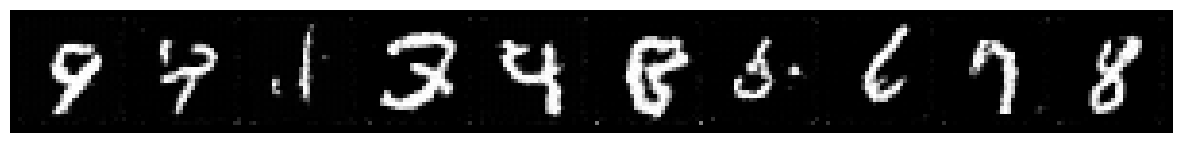

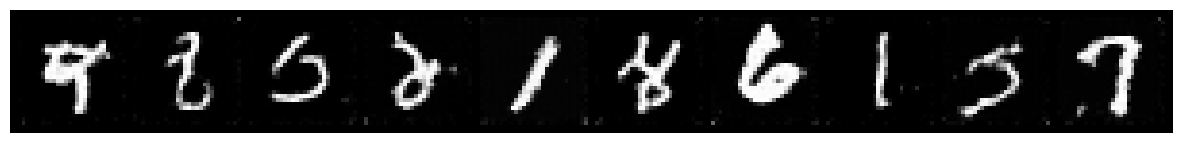

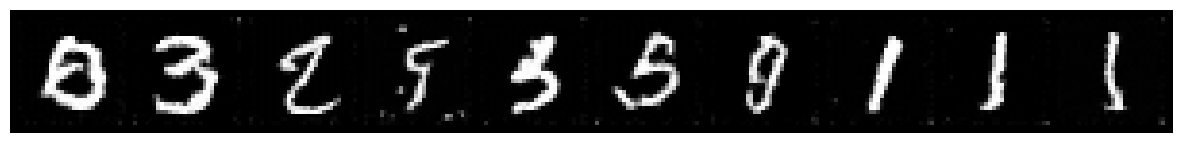

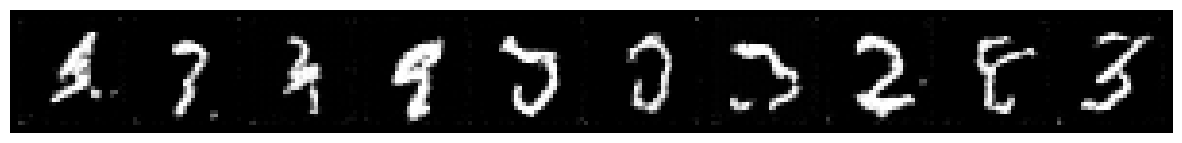

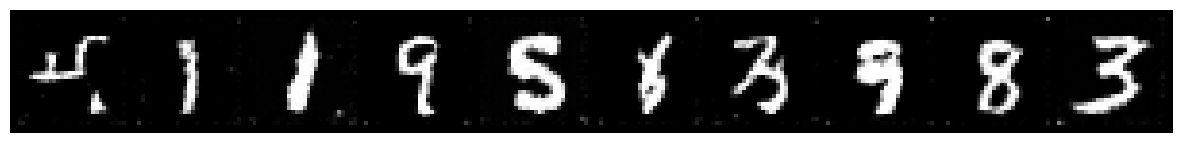

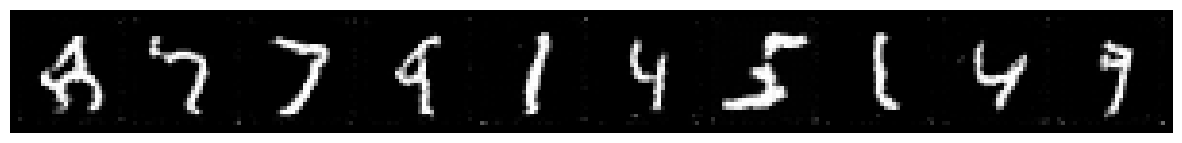

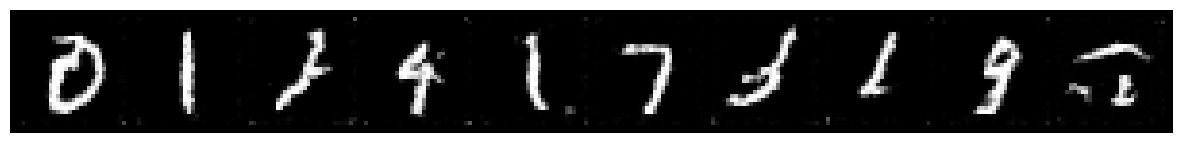

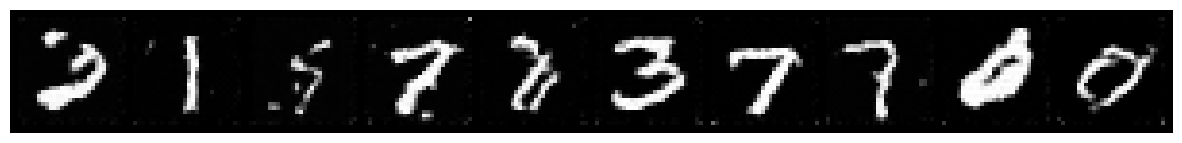

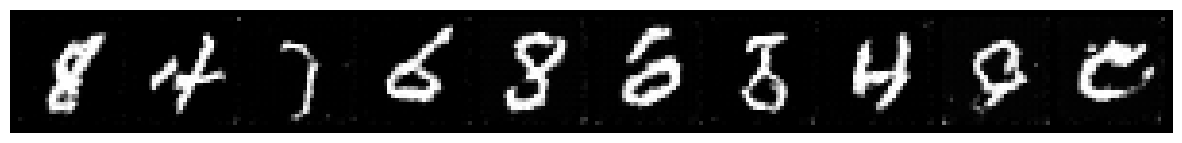

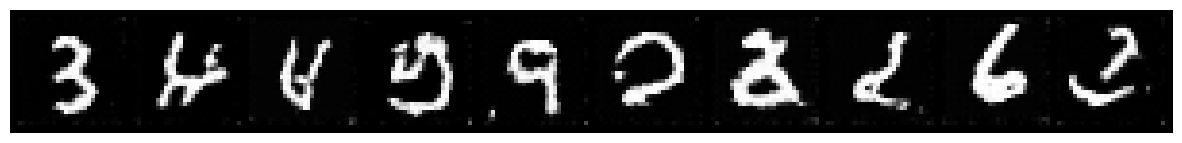

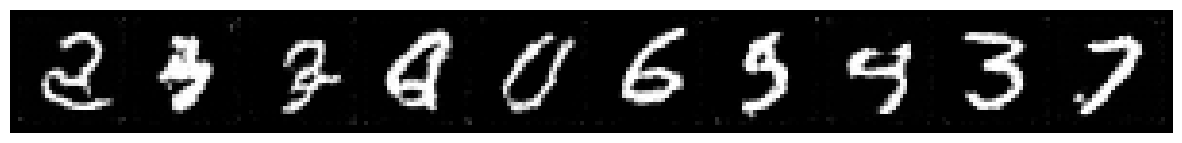

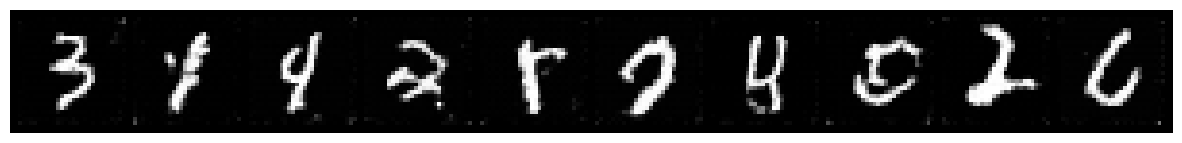

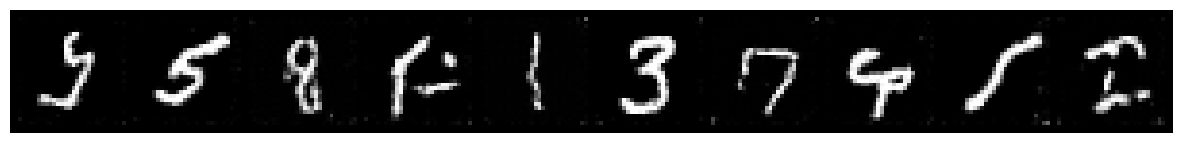

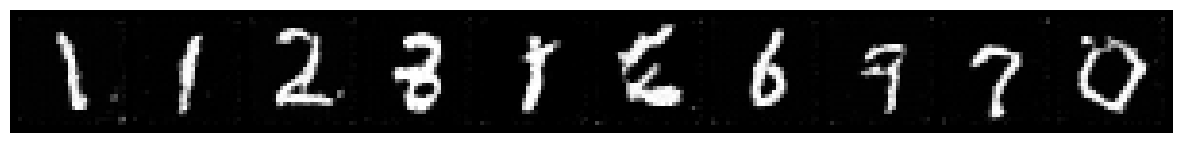

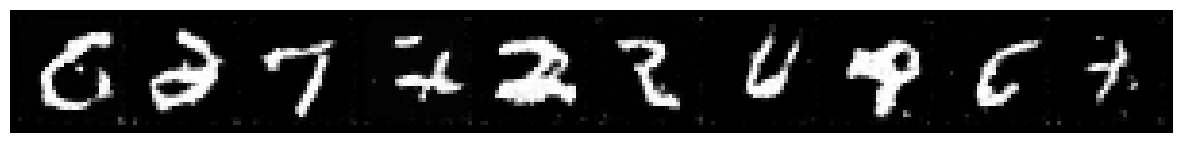

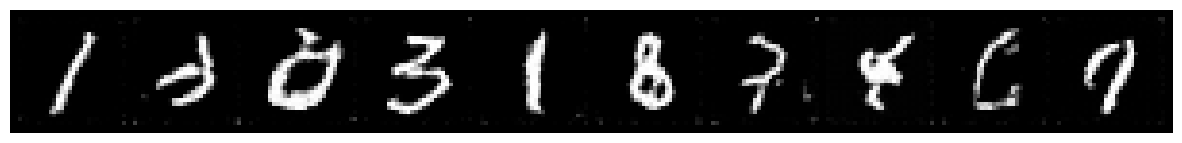

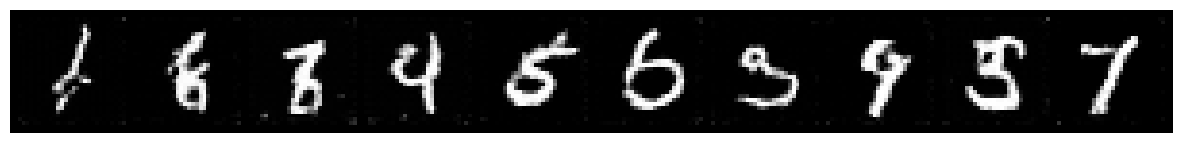

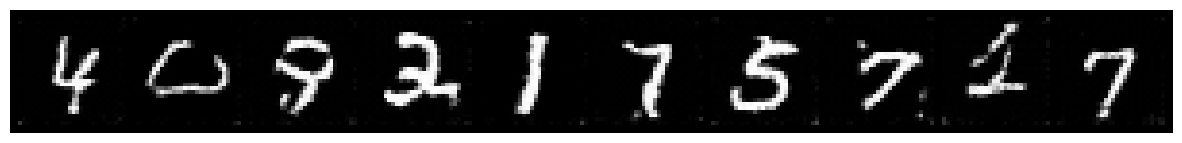

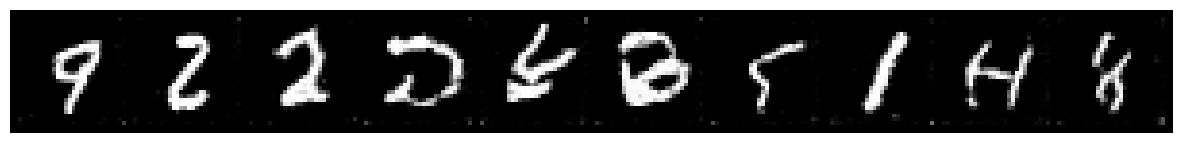

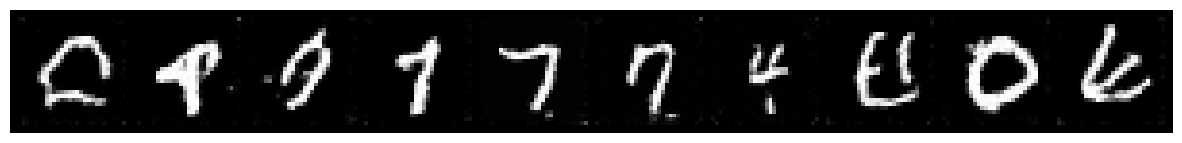

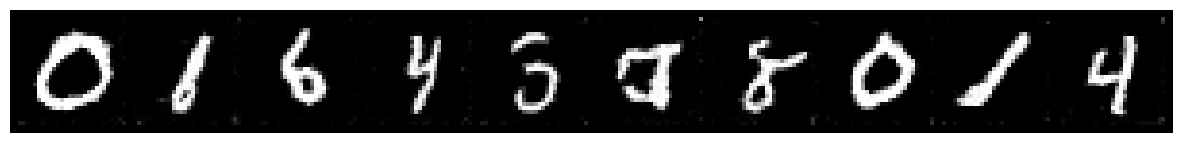

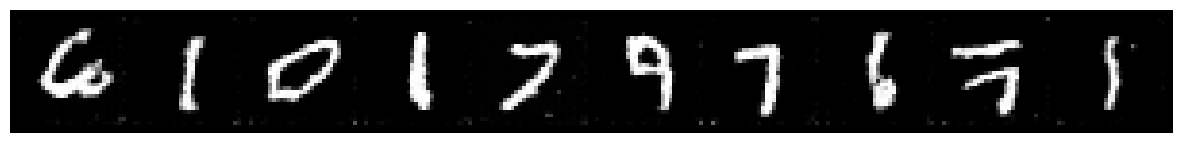

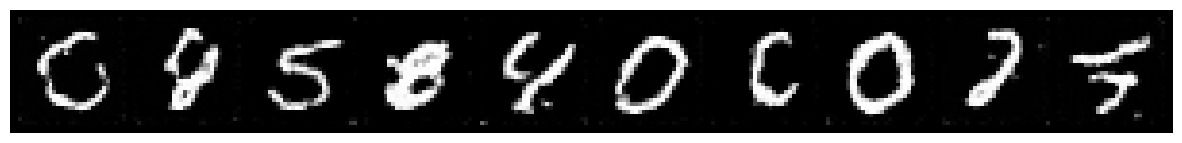

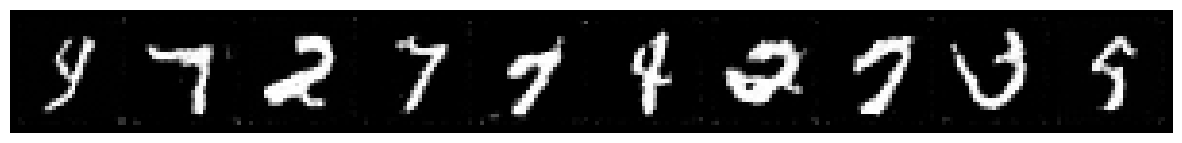

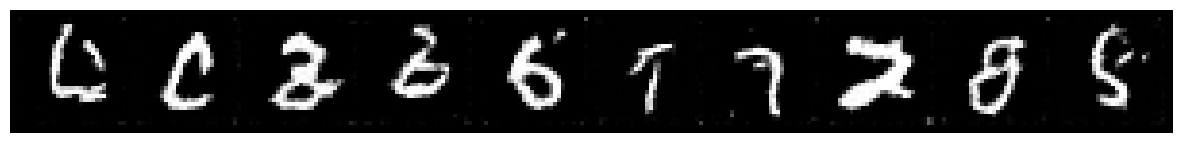

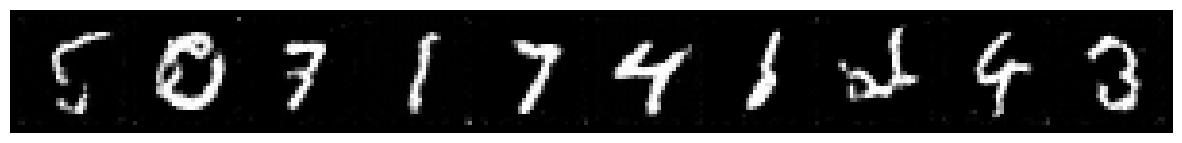

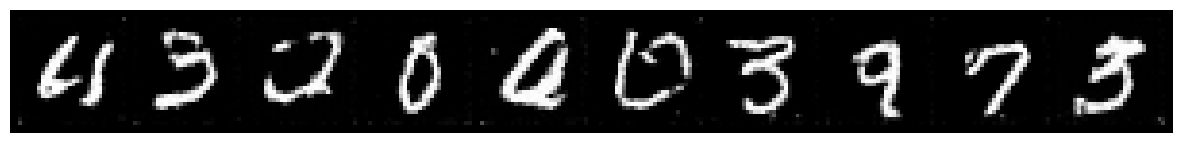

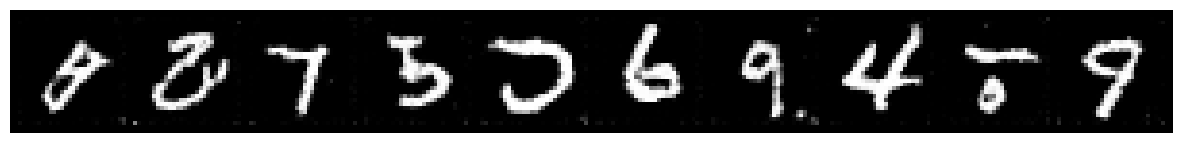

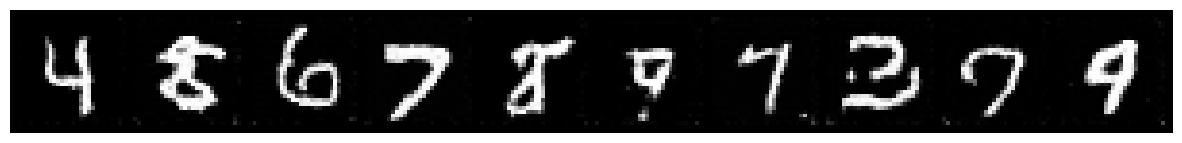

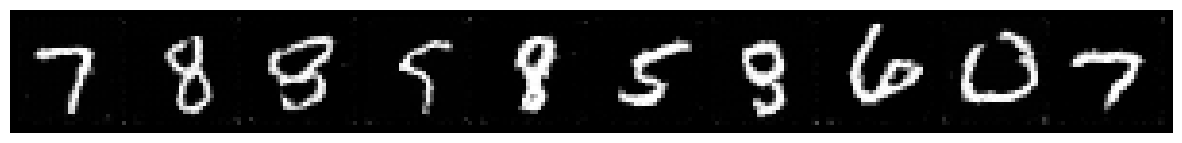

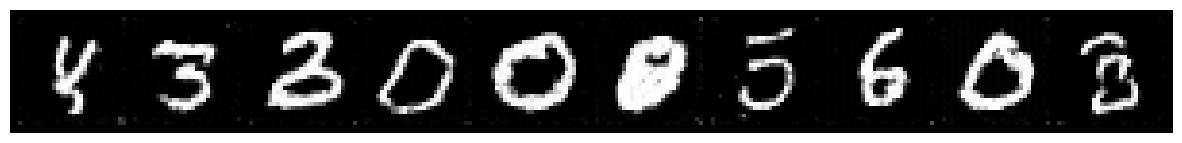

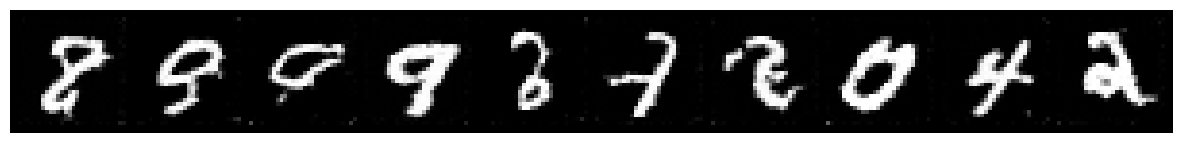

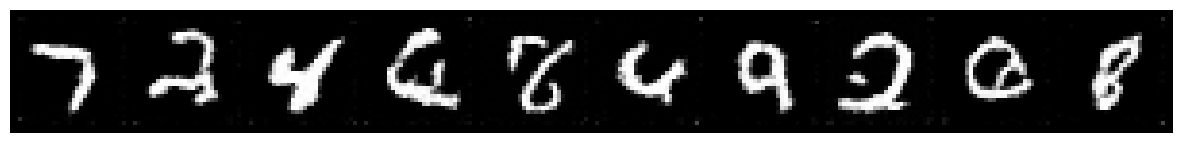

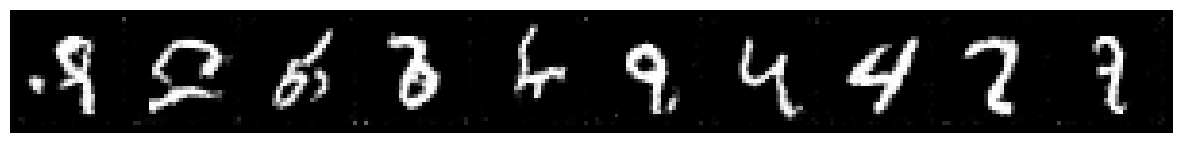

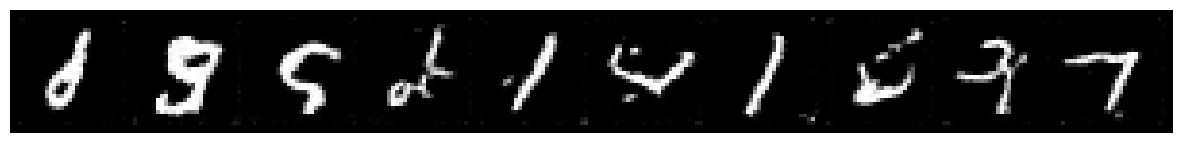

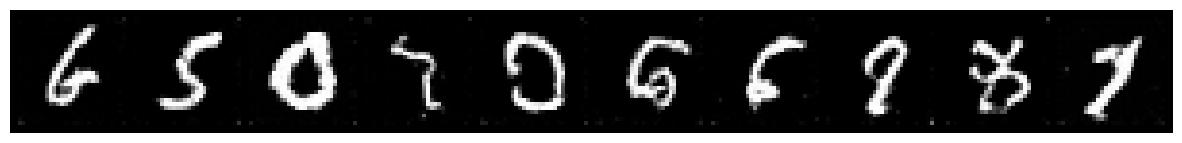

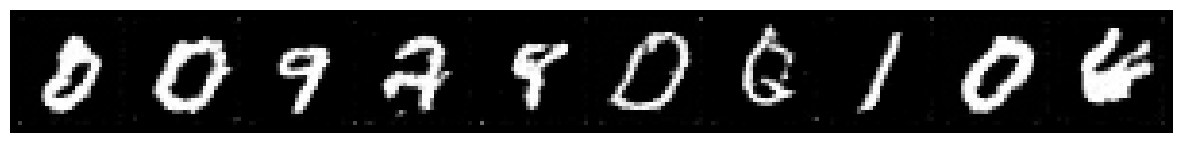

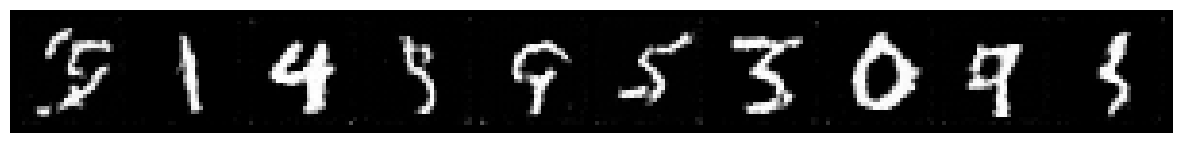

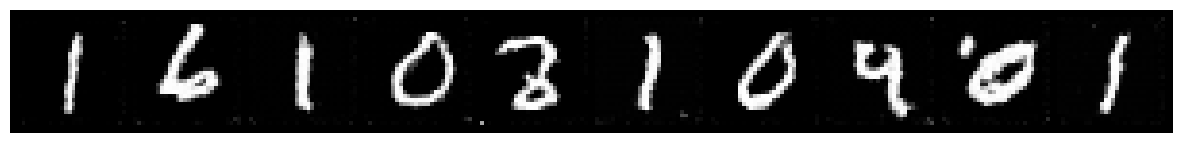

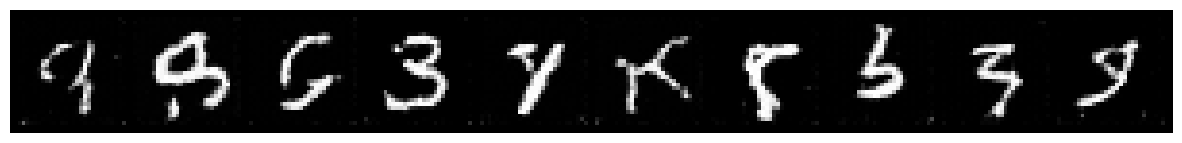

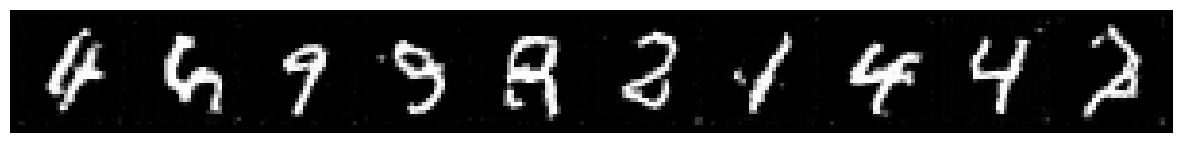

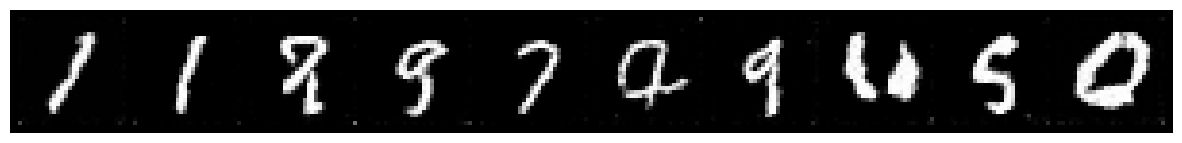

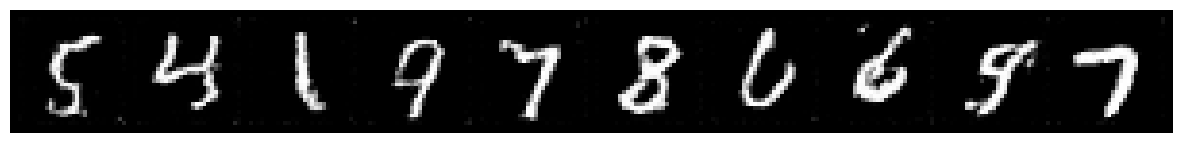

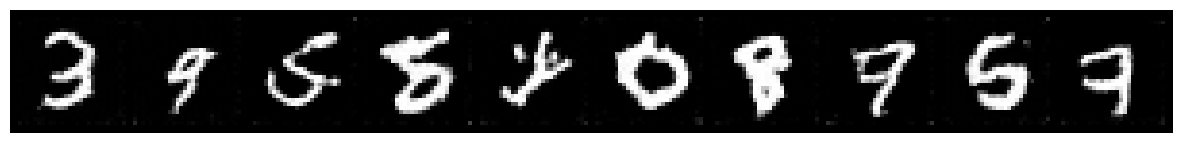

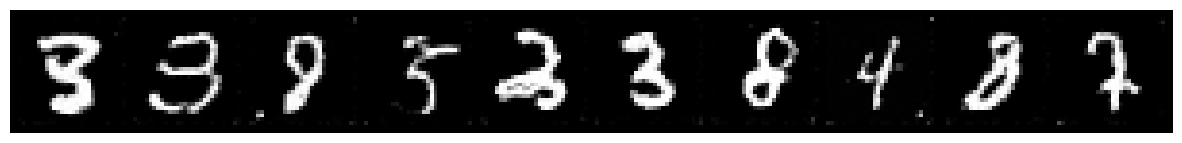

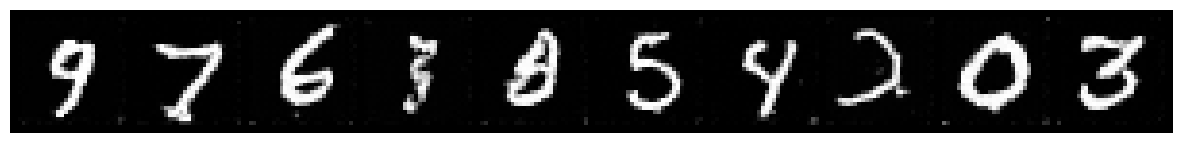

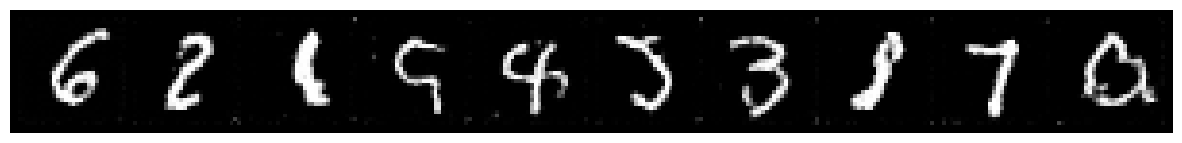

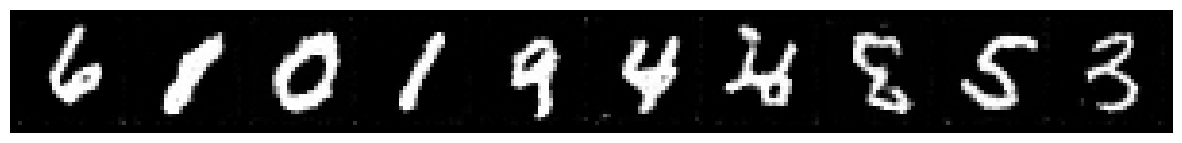

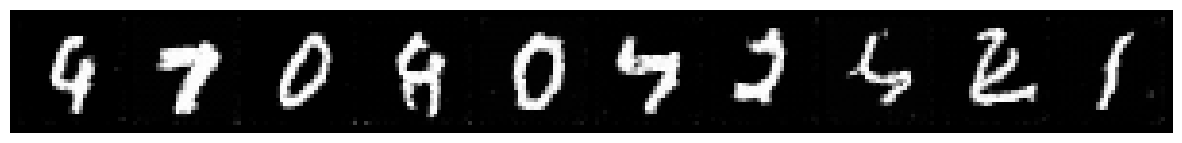

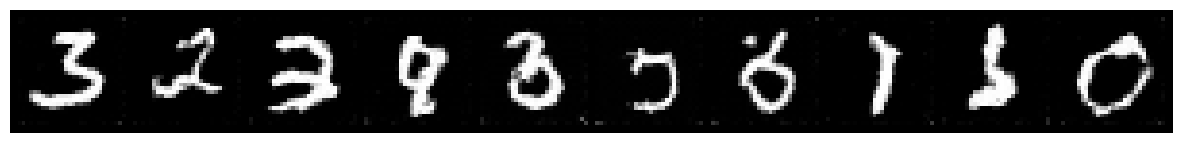

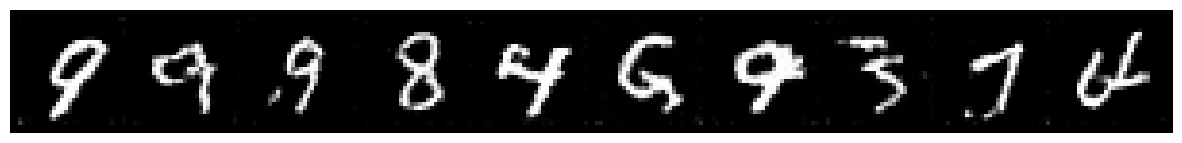

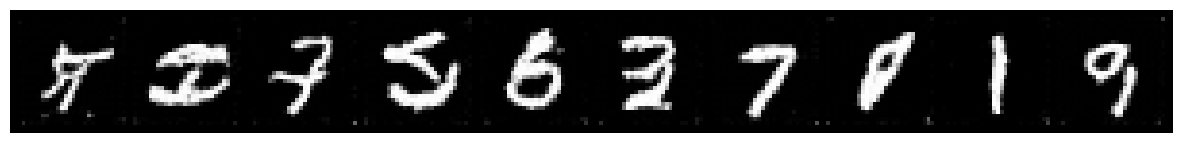

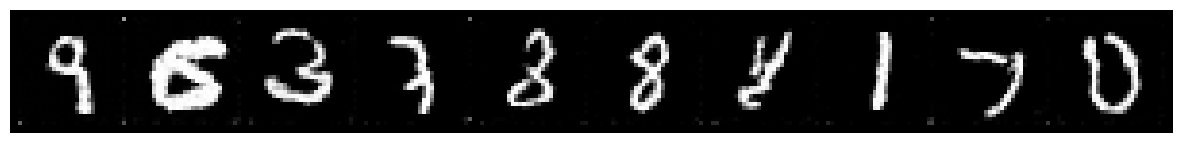

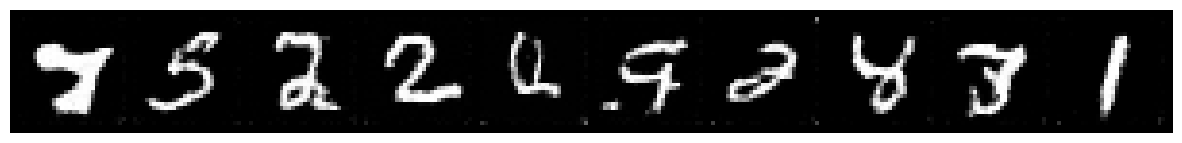

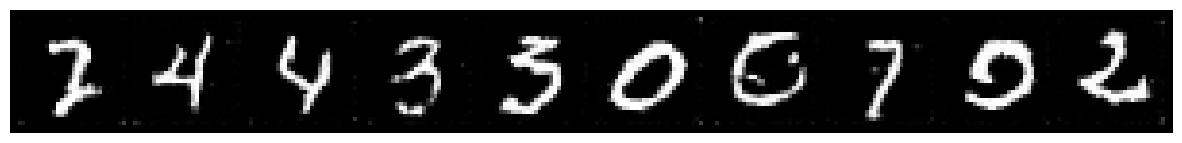

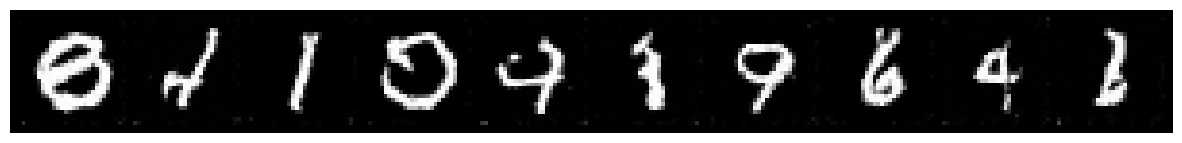

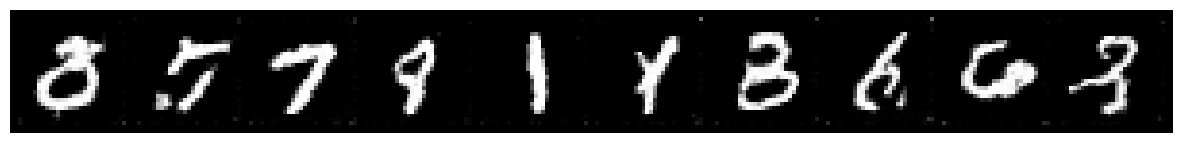

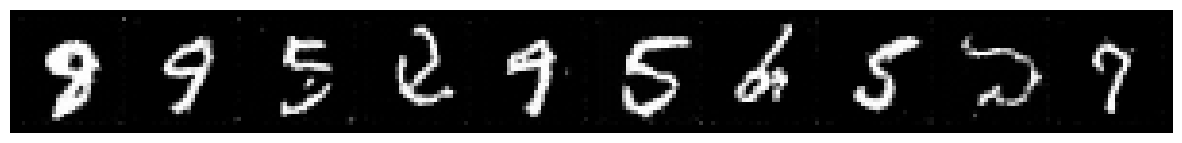

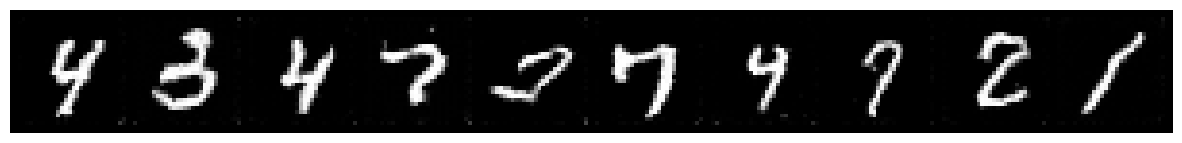

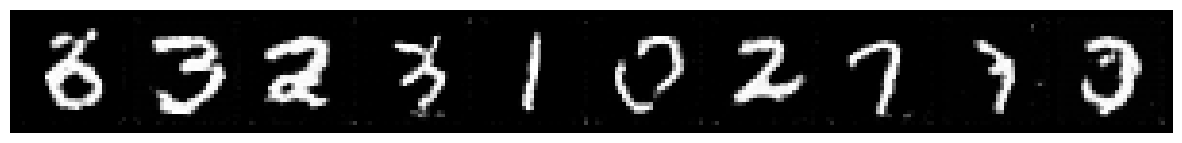

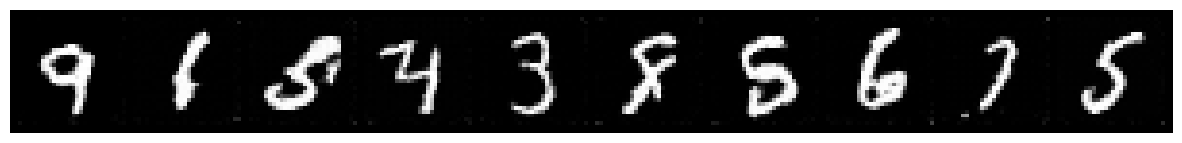

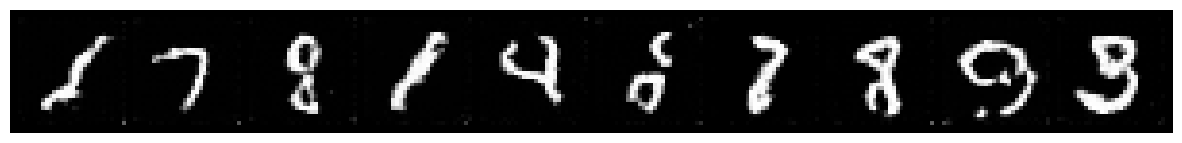

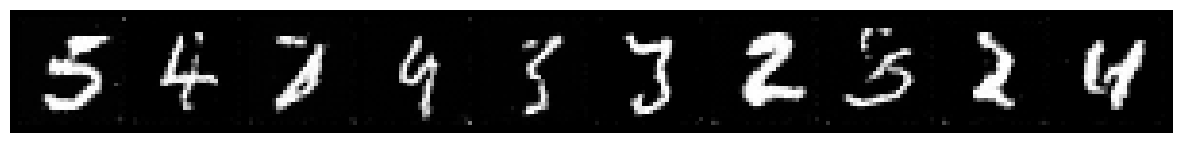

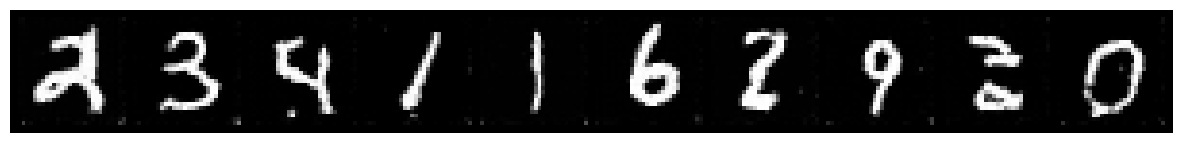

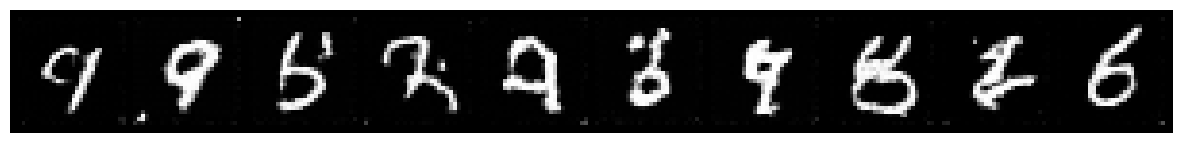

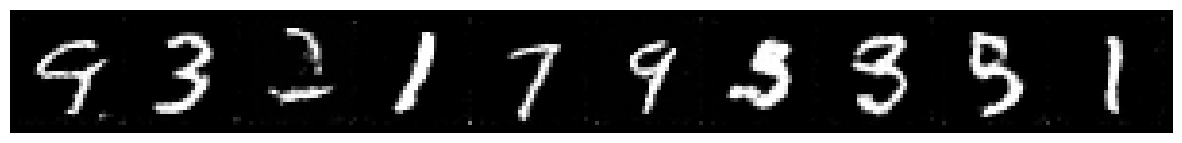

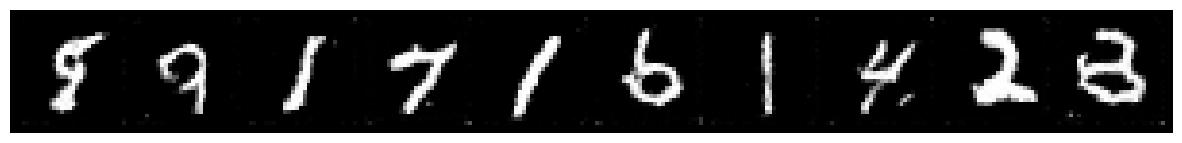

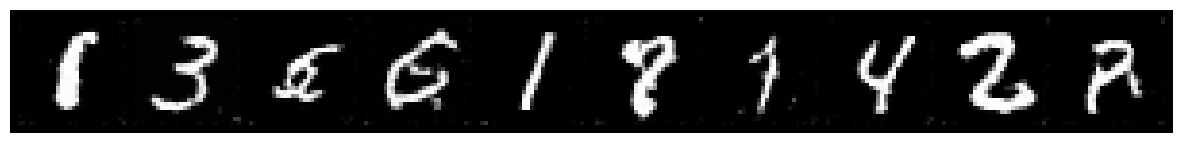

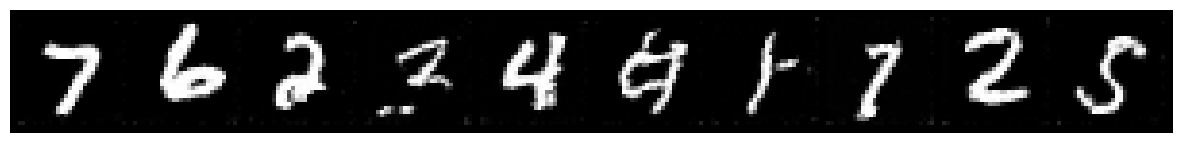

Training complete!


In [14]:
def reporter(model):
    """Callback function used for plotting images during training"""

    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        # Sample using Euler method with 50 steps
        samples = model.sample((nsamples, 28*28), num_steps=50, method='euler').cpu()

        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples + 1) / 2
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.figure(figsize=(15, 2))
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()

# Call training loop
print("Starting training...")
train_losses, ema_model = train(
    model, optimizer, scheduler, dataloader_train,
    epochs=epochs, device=device, ema=True, per_epoch_callback=reporter
)
print("Training complete!")

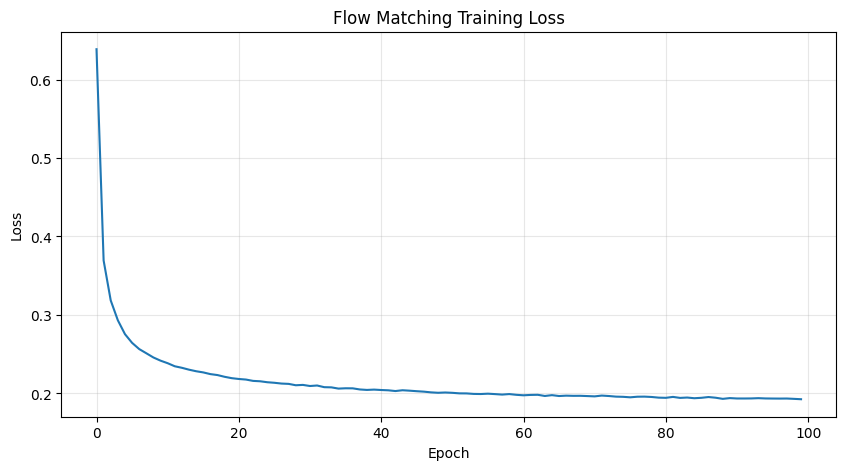

Final training loss: 0.1926


In [15]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Flow Matching Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final training loss: {train_losses[-1]:.4f}")

## 4. Evaluation Metrics Implementation

We implement **Inception Score (IS)** to evaluate the quality of generated samples.

### Inception Score (IS)
- Measures both quality and diversity of generated images
- Higher scores indicate better quality
- Formula: IS = exp(E[KL(p(y|x) || p(y))])

In [28]:
class MNISTClassifier(nn.Module):
    """Simple CNN classifier for MNIST (for Inception Score calculation)"""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_features(self, x):
        """Extract features for FID calculation (before final classifier layer)"""
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return x  # Return 128-dim features before final classification


def train_classifier(classifier, dataloader, epochs=5, device='cuda'):
    """Train MNIST classifier for Inception Score calculation"""
    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    print("Training MNIST classifier for evaluation...")
    classifier.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = images.view(-1, 1, 28, 28).to(device)
            images = (images + 1) / 2  # Convert from [-1, 1] to [0, 1]
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = classifier(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        accuracy = 100. * correct / total
        print(f"Epoch {epoch+1}: Loss={total_loss/len(dataloader):.4f}, Acc={accuracy:.2f}%")

    print(f"Classifier training complete! Final accuracy: {accuracy:.2f}%")
    return classifier


def calculate_fid(real_images, fake_images, classifier, device):
    """
    Calculate Fréchet Inception Distance using trained classifier features

    FID = ||μ_r - μ_g||² + Tr(Σ_r + Σ_g - 2√(Σ_r·Σ_g))
    """
    classifier.eval()

    # Extract features in batches
    with torch.no_grad():
        real_features = []
        for i in range(0, len(real_images), 100):
            batch = real_images[i:i+100].to(device)
            batch = (batch + 1) / 2  # Convert to [0, 1]
            features = classifier.get_features(batch)
            real_features.append(features.cpu().numpy())
        real_features = np.concatenate(real_features, axis=0)

        fake_features = []
        for i in range(0, len(fake_images), 100):
            batch = fake_images[i:i+100].to(device)
            batch = (batch + 1) / 2  # Convert to [0, 1]
            features = classifier.get_features(batch)
            fake_features.append(features.cpu().numpy())
        fake_features = np.concatenate(fake_features, axis=0)

    # Calculate statistics
    mu_real = np.mean(real_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)

    mu_fake = np.mean(fake_features, axis=0)
    sigma_fake = np.cov(fake_features, rowvar=False)

    # Calculate FID
    diff = mu_real - mu_fake
    covmean = linalg.sqrtm(sigma_real.dot(sigma_fake))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2*covmean)
    return fid


def calculate_inception_score(images, classifier, device='cuda', splits=10):
    """
    Calculate Inception Score for generated images

    Args:
        images: Tensor of images (B, 1, 28, 28) in [-1, 1]
        classifier: Trained MNIST classifier
        device: Device to use
        splits: Number of splits for calculating mean and std

    Returns:
        mean, std: Mean and standard deviation of IS
    """
    classifier.eval()
    N = len(images)

    # Get predictions
    preds = []
    with torch.no_grad():
        for i in range(0, N, 100):
            batch = images[i:i+100].to(device)
            batch = (batch + 1) / 2  # Convert to [0, 1]
            pred = F.softmax(classifier(batch), dim=1)
            preds.append(pred.cpu().numpy())

    preds = np.concatenate(preds, axis=0)

    # Calculate IS for each split
    scores = []
    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean(np.sum(part * (np.log(part + 1e-10) - np.log(py + 1e-10)), axis=1))))

    return np.mean(scores), np.std(scores)


## 5. Setup Evaluation Model

Train a classifier for Inception Score calculation.

In [29]:
# Initialize and train classifier
print("Setting up evaluation model...")
classifier = MNISTClassifier().to(device)

# Train classifier - this will be used for both FID and IS
classifier = train_classifier(classifier, dataloader_train, epochs=5, device=device)
print("Classifier ready! Will be used for both FID (features) and IS (predictions)")


Setting up evaluation model...
Training MNIST classifier for evaluation...


Epoch 1/5:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1: Loss=0.2649, Acc=92.17%


Epoch 2/5:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2: Loss=0.0578, Acc=98.29%


Epoch 3/5:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3: Loss=0.0376, Acc=98.83%


Epoch 4/5:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4: Loss=0.0269, Acc=99.17%


Epoch 5/5:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5: Loss=0.0189, Acc=99.42%
Classifier training complete! Final accuracy: 99.42%
Classifier ready! Will be used for both FID (features) and IS (predictions)


In [30]:
# Load real test images for FID evaluation
print("Loading real test images...")
real_images = []
for x, _ in dataloader_test:
    real_images.append(x)
real_images = torch.cat(real_images, dim=0)[:10000].view(-1, 1, 28, 28)
print(f"Loaded {len(real_images)} real images for FID calculation")


Loading real test images...
Loaded 10000 real images for FID calculation


## 6. Sampling Experiments

In [31]:
# Experiment 1: Sample with different numbers of steps
print("\n" + "="*80)
print("EXPERIMENT 1: SAMPLING WITH DIFFERENT STEP COUNTS")
print("="*80)

# Use EMA model for sampling
eval_model = ema_model.module
eval_model.eval()

num_steps_list = [10, 25, 50, 100]
num_samples = 10000
batch_size = 100

sampling_results = {}

for num_steps in num_steps_list:
    print(f"\nSampling with {num_steps} steps...")

    all_samples = []
    time_for_100 = None  # Specifically measure time for first 100 samples

    for i in tqdm(range(0, num_samples, batch_size), desc=f"{num_steps} steps"):
        n = min(batch_size, num_samples - i)

        # Measure time for the first batch (100 samples)
        if i == 0:
            start_time_100 = time.time()
            samples = eval_model.sample((n, 28*28), num_steps=num_steps, method='euler')
            time_for_100 = time.time() - start_time_100
        else:
            samples = eval_model.sample((n, 28*28), num_steps=num_steps, method='euler')

        all_samples.append(samples.cpu())

    all_samples = torch.cat(all_samples, dim=0)

    sampling_results[num_steps] = {
        'samples': all_samples,
        'time_per_100': time_for_100,
        'nfe': num_steps  # Number of function evaluations
    }

    print(f"Time to generate 100 samples: {time_for_100:.2f}s")



EXPERIMENT 1: SAMPLING WITH DIFFERENT STEP COUNTS

Sampling with 10 steps...


10 steps:   0%|          | 0/100 [00:00<?, ?it/s]

Time to generate 100 samples: 0.03s

Sampling with 25 steps...


25 steps:   0%|          | 0/100 [00:00<?, ?it/s]

Time to generate 100 samples: 0.06s

Sampling with 50 steps...


50 steps:   0%|          | 0/100 [00:00<?, ?it/s]

Time to generate 100 samples: 0.11s

Sampling with 100 steps...


100 steps:   0%|          | 0/100 [00:00<?, ?it/s]

Time to generate 100 samples: 0.21s


## 7. Evaluation: Inception Score

Calculate Inception Score for samples generated with different step counts.

In [32]:
print("\n" + "="*80)
print("EVALUATING SAMPLES: FID AND INCEPTION SCORE")
print("="*80)

evaluation_results = {}

for num_steps, result in sampling_results.items():
    print(f"\nEvaluating {num_steps} steps...")

    # Reshape to images
    gen_images = result['samples'].view(-1, 1, 28, 28)

    # Calculate FID (using trained classifier features)
    print("  Calculating FID...")
    fid = calculate_fid(real_images, gen_images, classifier, device)
    print(f"  FID: {fid:.2f}")

    # Calculate IS (using trained classifier predictions)
    print("  Calculating Inception Score...")
    is_mean, is_std = calculate_inception_score(gen_images, classifier, device)
    print(f"  IS: {is_mean:.2f} ± {is_std:.2f}")
    print(f"  Time per 100 samples: {result['time_per_100']:.2f}s")

    evaluation_results[num_steps] = {
        'fid': fid,
        'is_mean': is_mean,
        'is_std': is_std,
        'time_per_100': result['time_per_100'],
        'nfe': result['nfe']
    }

print("\nEvaluation complete!")



EVALUATING SAMPLES: FID AND INCEPTION SCORE

Evaluating 10 steps...
  Calculating FID...


/tmp/ipython-input-95861719.py:100: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean = linalg.sqrtm(sigma_real.dot(sigma_fake))


  FID: 99.50
  Calculating Inception Score...
  IS: 7.90 ± 0.08
  Time per 100 samples: 0.03s

Evaluating 25 steps...
  Calculating FID...
  FID: 60.85
  Calculating Inception Score...
  IS: 8.20 ± 0.09
  Time per 100 samples: 0.06s

Evaluating 50 steps...
  Calculating FID...
  FID: 55.09
  Calculating Inception Score...
  IS: 8.23 ± 0.08
  Time per 100 samples: 0.11s

Evaluating 100 steps...
  Calculating FID...
  FID: 55.17
  Calculating Inception Score...
  IS: 8.31 ± 0.10
  Time per 100 samples: 0.21s

Evaluation complete!
